## AlexNet

> 합성곱 층 총 5개와 완전연결층 3개로 구성되어 있으며, 
마지막 완결연결층은 카테고리 1000개를 분류하기 위한 소프트맥스 활성화 함수를 사용하고 있음.

|계층 유형|특성 맵|크기|커널 크기|스트라이드|활성화 함수|
|------|---|---|---|---|---|
|이미지|1|227X227|-|-|-|
|합성곱층|96|55X55|11X11|4|ReLU|
|최대 풀링층|96|27X27|3X3|2|-|
|합성곱층|256|27X27|5X5|1|ReLU|
|최대 풀링층|256|13X13|3X3|2|-|
|합성곱층|384|13X13|3X3|1|ReLU|
|합성곱층|384|13X13|3X3|1|ReLU|
|합성곱층|256|13X13|3X3|1|ReLU|
|최대 풀링층|256|6X6|3X3|2|-|
|완전연결층|-|4096|-|-|ReLU|
|완전연결층|-|4096|-|-|ReLU|
|완전연결층|-|1000|-|-|Softmax|

> 네트워크에는 학습 가능한 변수가 6600만개 있음. 
네트워크에 대한 입력은 227X227X3 크기의 RGB 이미지이며, 각 클래스(카테고리)에 해당하는 1000X1 확률벡터를 출력함.

In [30]:
# import library
import torch
import torchvision
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from torch.autograd import Variable
from torch import optim
import torch.nn as nn
import torch.nn.functional as F
import os
import cv2
import random
import time
from PIL import Image
from tqdm import tqdm_notebook as tqdm
import matplotlib.pyplot as plt
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [4]:
# data preprocessing
class ImageTransform() :
    def __init__(self, resize, mean, std) :
        self.data_transform = {
            'train' : transforms.Compose([
                    transforms.RandomResizedCrop(resize, scale=(0.5, 1.0)),
                    transforms.RandomHorizontalFlip(),
                    transforms.ToTensor(),
                    transforms.Normalize(mean, std)
            ]),
            'val' : transforms.Compose([
                    transforms.Resize(256),
                    transforms.CenterCrop(resize),
                    transforms.ToTensor(),
                    transforms.Normalize(mean, std)
            ])
        }
        
    def __call__(self, img, phase) :
        return self.data_transform[phase](img)

In [6]:
# data load & split
cat_dir = '../080289-main/chap06/data/dogs-vs-cats/Cat/'
dog_dir = '../080289-main/chap06/data/dogs-vs-cats/Dog/'

cat_images_filepath = sorted([os.path.join(cat_dir, f) for f in os.listdir(cat_dir)])
dog_images_filepath = sorted([os.path.join(dog_dir, f) for f in os.listdir(dog_dir)])

images_filepath = [*cat_images_filepath, *dog_images_filepath]
correct_images_filepath = [i for i in images_filepath if cv2.imread(i) is not None]

random.seed(3)
random.shuffle(correct_images_filepath)
train_image_filepaths = correct_images_filepath[:400]
val_image_filepaths = correct_images_filepath[400:-10]
test_image_filepaths = correct_images_filepath[-10:]

print(len(train_image_filepaths), len(val_image_filepaths), len(test_image_filepaths))

400 92 10


In [7]:
# define custom dataset
class DogvsCatDataset(Dataset) :
    def __init__(self, file_list, transform=None, phase='train') :
        self.file_list = file_list
        self.transform = transform
        self.phase = phase
        
    def __len__(self) :
        return len(self.file_list)
    
    def __getitem__(self, idx) :
        img_path = self.file_list[idx]
        img = Image.open(img_path)
        img_transformed = self.transform(img, self.phase)
        
        label = img_path.split('/')[-1].split('.')[0]
        if label == 'dog' :
            label = 1
        elif label == 'cat' :
            label = 0
            
        return img_transformed, label

In [8]:
# define variables

size = 256
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)
batch_size = 32

In [10]:
train_dataset = DogvsCatDataset(train_image_filepaths, transform=ImageTransform(size, mean, std),
                               phase='train')
val_dataset = DogvsCatDataset(val_image_filepaths, transform=ImageTransform(size, mean, std),
                             phase='val')
test_dataset = DogvsCatDataset(val_image_filepaths, transform=ImageTransform(size, mean, std),
                            phase='val')

index = 0
print(train_dataset.__getitem__(index)[0].size())
print(train_dataset.__getitem__(index)[1])

torch.Size([3, 256, 256])
0


In [11]:
# load dataset to memory
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
dataloader_dict = {'train' : train_dataloader, 'val' : val_dataloader}

batch_iterator = iter(train_dataloader)
inputs, label = next(batch_iterator)
print(inputs.size())
print(label)

torch.Size([32, 3, 256, 256])
tensor([1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1,
        1, 0, 1, 1, 1, 1, 0, 0])


In [16]:
# define model network
class AlexNet(nn.Module) :
    def __init__(self) -> None :
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256*6*6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 512),
            nn.ReLU(inplace=True),
            nn.Linear(512, 2),)
        
    def forward(self, x :torch.Tensor) -> torch.Tensor :
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

In [17]:
# create model
model = AlexNet()
model.to(device)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [18]:
# optimizer, loss function
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
criterion = nn.CrossEntropyLoss()

In [19]:
# check model Network 
from torchsummary import summary
summary(model, input_size=(3, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 63, 63]          23,296
              ReLU-2           [-1, 64, 63, 63]               0
         MaxPool2d-3           [-1, 64, 31, 31]               0
            Conv2d-4          [-1, 192, 31, 31]         307,392
              ReLU-5          [-1, 192, 31, 31]               0
         MaxPool2d-6          [-1, 192, 15, 15]               0
            Conv2d-7          [-1, 384, 15, 15]         663,936
              ReLU-8          [-1, 384, 15, 15]               0
            Conv2d-9          [-1, 256, 15, 15]         884,992
             ReLU-10          [-1, 256, 15, 15]               0
           Conv2d-11          [-1, 256, 15, 15]         590,080
             ReLU-12          [-1, 256, 15, 15]               0
        MaxPool2d-13            [-1, 256, 7, 7]               0
AdaptiveAvgPool2d-14            [-1, 25

In [21]:
# define training function
def train_model(model, dataloader_dict, criterion, optimizer, n_epochs) :
    since = time.time()
    best_acc = 0.0
    
    for epoch in range(n_epochs) :
        print(f'Epoch {epoch+1}/{n_epochs}')
        print('-' * 20)
        
        for phase in ['train', 'val'] :
            if phase == 'train' :
                model.train()
                
            else :
                model.eval()
                
            epoch_loss = 0.0
            epoch_corrects = 0
            
            for inputs, labels in tqdm(dataloader_dict[phase]) :
                inputs = inputs.to(device)
                labels = labels.to(device)
                optimizer.zero_grad()
                
                with torch.set_grad_enabled(phase == 'train') :
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    
                    if phase == 'train' :
                        loss.backward()
                        optimizer.step()
                        
                epoch_loss += loss.item() * inputs.size(0)
                epoch_corrects += torch.sum(preds == labels.data)
                
            epoch_loss = epoch_loss / len(dataloader_dict[phase].dataset)
            epoch_acc = epoch_corrects.double() / len(dataloader_dict[phase].dataset)
            
            print(f'{phase} Loss : {epoch_loss:.4f} Acc : {epoch_acc:.4f}')
        
    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed %60:0f}')

    return model

In [24]:
n_epochs = 10
model = train_model(model, dataloader_dict, criterion, optimizer, n_epochs)

Epoch 1/10
--------------------


C:\Users\PC\anaconda3\envs\yeseul\lib\site-packages\ipykernel_launcher.py:20: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss : 0.6925 Acc : 0.5200


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss : 0.6958 Acc : 0.4239
Epoch 2/10
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss : 0.6927 Acc : 0.5200


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss : 0.6961 Acc : 0.4239
Epoch 3/10
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss : 0.6927 Acc : 0.5200


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss : 0.6961 Acc : 0.4239
Epoch 4/10
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss : 0.6928 Acc : 0.5200


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss : 0.6965 Acc : 0.4239
Epoch 5/10
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss : 0.6925 Acc : 0.5200


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss : 0.6967 Acc : 0.4239
Epoch 6/10
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss : 0.6925 Acc : 0.5200


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss : 0.6967 Acc : 0.4239
Epoch 7/10
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss : 0.6926 Acc : 0.5200


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss : 0.6969 Acc : 0.4239
Epoch 8/10
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss : 0.6922 Acc : 0.5200


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss : 0.6971 Acc : 0.4239
Epoch 9/10
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss : 0.6926 Acc : 0.5200


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss : 0.6970 Acc : 0.4239
Epoch 10/10
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss : 0.6921 Acc : 0.5200


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss : 0.6971 Acc : 0.4239
Training complete in 1m 54.776388


In [37]:
# make prediction
import pandas as pd
id_list = []
pred_list = []
_id = 0
with torch.no_grad() :
    for test_path in tqdm(test_image_filepaths) :
        img = Image.open(test_path)
        _id = test_path.split('/')[-1].split('.')[1]
        transform = ImageTransform(size, mean, std)
        img = transform(img, phase='val')
        img = img.unsqueeze(0)
        img = img.to(device)
        
        model.eval()
        outputs = model(img)
        preds = F.softmax(outputs, dim=1)[:, 1].tolist()
        
        id_list.append(_id)
        pred_list.append(preds[0])
        
res = pd.DataFrame({'id' : id_list,
                   'label' : pred_list})
res.to_csv('./alexnet.csv', index=False)

C:\Users\PC\anaconda3\envs\yeseul\lib\site-packages\ipykernel_launcher.py:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  import sys


  0%|          | 0/10 [00:00<?, ?it/s]

In [38]:
res.head()

,id,label
0,14,0.487171
1,160,0.487278
2,91,0.486792
3,150,0.487695
4,69,0.487513


In [35]:
# result visualization
class_ = classes = {0 : 'cat', 1 : 'dog'}

def display_image_grid(images_filepaths, pred_labels=(), cols=5) :
    rows = len(images_filepaths) // cols
    figure, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(12, 6))
    for i, image_filepath in enumerate(images_filepaths) :
        image = cv2.imread(image_filepath)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        a = random.choice(res['id'].values)
        label = res.loc[res['id'] == a, 'label'].values[0]
        
        if label > 0.5 :
            label = 1
        else :
            label = 0
            
        ax.ravel()[i].imshow(image)
        ax.ravel()[i].set_title(class_[label])
        ax.ravel()[i].set_axis_off()
        
    plt.tight_layout()
    plt.show()

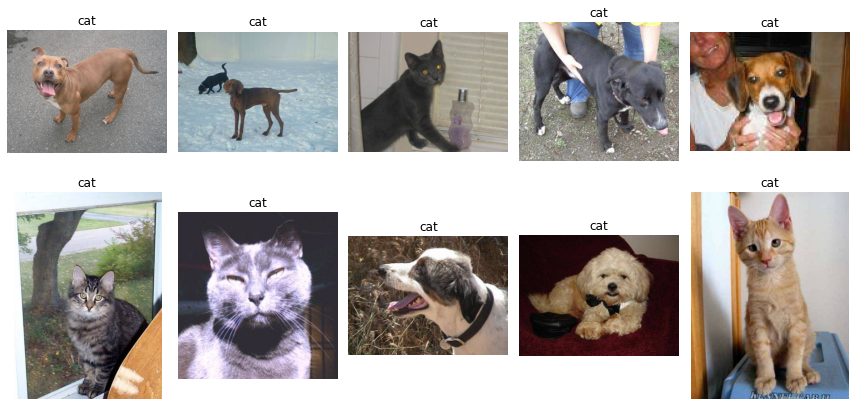

In [36]:
display_image_grid(test_image_filepaths)